<a href="https://colab.research.google.com/github/xin1118/Image-Generation-awesome/blob/main/03_train_NICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Cauliflower61/Flow-based-models.git

Cloning into 'Flow-based-models'...
remote: Enumerating objects: 148, done.
remote: Total 148 (delta 0), reused 0 (delta 0), pack-reused 148 (from 1)
Receiving objects: 100% (148/148), 207.57 MiB | 14.93 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Updating files: 100% (23/23), done.


In [3]:
import sys
sys.path.append('/content/Flow-based-models/NICE')

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataset import MyData
from model.NICE import Nice
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


# loss function of per batch #
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()

    def forward(self, y_pre, log_s):
        return 1/2 * torch.mean(torch.sum(y_pre ** 2, dim=1)) - torch.sum(log_s)


# parameters definition #
t_npy = '/content/Flow-based-models/NICE/datasets/MNIST_train.npy'
v_npy = '/content/Flow-based-models/NICE/datasets/MNIST_valid.npy'
Checkpoint_dir = '/content/Flow-based-models/NICE/Checkpoint'
log_dir = '/content/Flow-based-models/NICE/TensorBoardSave/NICE'
device = 'cuda:0'
batch_size = 60
learning_rate = 0.001
epoch_num = 30

# load data #
train_dataset = MyData(t_npy, v_npy)
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
# TensorBoard #
writer = SummaryWriter(log_dir)
batch_num = len(train_dataloader)

# generate model #
net = Nice(input_dim=28*28, hidden_dim=1000).to(device)
MyLoss = LossFunction()
optim = torch.optim.Adam(net.parameters(), lr=learning_rate)


# model train #
net.train()
for epoch in range(epoch_num):
    total_loss = 0
    iter1 = 0
    loop = tqdm(train_dataloader, desc='Train')
    for train_data in loop:
        batch = train_data.shape[0]
        train_data = train_data.view(batch, -1).to(device)
        optim.zero_grad()
        z = net((train_data, False))
        loss = MyLoss(z, net.scale)
        total_loss += loss.data * batch
        loss.backward()
        optim.step()
        writer.add_scalar(tag="training loss", scalar_value=loss,
                          global_step=epoch * batch_num + iter1)
        loop.set_description(f'Epoch [{epoch + 1}/{epoch_num}]')
        loop.set_postfix(loss=loss.data.item())
        iter1 += 1

    torch.save(net.state_dict(), Checkpoint_dir + 'epoch' + str(epoch+1) + '.pkl')
writer.close()

Epoch [30/30]: 100%|██████████| 1000/1000 [00:13<00:00, 75.24it/s, loss=-2.98e+3]


<ipython-input-7-f489a682b20e>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(load_file))


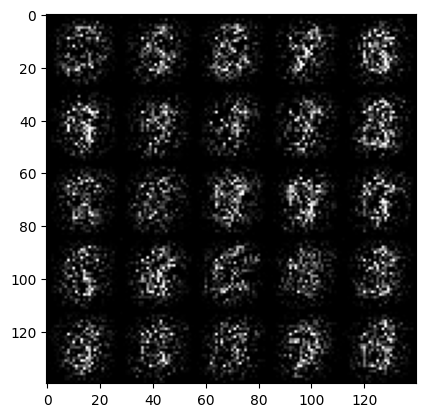

In [7]:
import torch
from model.NICE import Nice
import numpy as np
import matplotlib.pyplot as plt

load_file = '/content/Flow-based-models/NICE/Checkpoint/epoch10.pkl'
device = 'cuda:0'
pixel = 28
# load model #
net = Nice(input_dim=pixel**2, hidden_dim=1000).to(device)
net.load_state_dict(torch.load(load_file))
net.eval()
# sample #
num = 5
save_image = np.zeros(shape=(pixel*num, pixel*num))
for i in range(num):
    for j in range(num):
        z = torch.randn(size=(1, pixel*pixel)).to(device)
        out = net.decode((z, True)).reshape((pixel, pixel)).detach().cpu().numpy()
        save_image[i * pixel: (i + 1) * pixel, j * pixel: (j + 1) * pixel] = out

save_image = np.clip(save_image * 255, 0, 255)
plt.imshow(save_image, cmap='gray')
plt.show()